## Importing libraries/modules

In [1]:
import utils
import numpy as np
import pandas as pd
import os

In [2]:
DATA_DIR = 'Data'
CACHE_DIR = 'Cache'
SPEAKER_INFO_FILE_PATH = os.path.join(DATA_DIR, 'speaker_attributes.parquet')
CACHE_FILE_PATH = os.path.join(CACHE_DIR, 'processed_data.json.bz2')

## Useful functions

In [3]:
@utils.cache_to_file_pickle("function-groupby_speaker", cache_dir = CACHE_DIR)
def groupby_speaker(input_file_path):
    """
    """
    speakers_dict = {}
    
    def processing_func(line):
        # Inner function can modify dictionary even without nonlocal keywork because dictionaries
        # are mutable objects. Nevertheless, for clarity:
        nonlocal speakers_dict
    
        # If no qids are available for the current quote, we drop it.
        if not line['qids']:
            return
            
        qids = tuple(line['qids']) if len(line['qids']) > 1 else line['qids'][0]

        if qids in speakers_dict:
            speakers_dict[qids]['quote_count'] += 1
            speakers_dict[qids]['speaker']     |= set([line['speaker']])
            speakers_dict[qids]['num_occurrences'].append(line['num_occurrences'])

        else:
            speakers_dict[qids] = {'quote_count': 1, \
                                   'speaker': set([line['speaker']]),
                                   'num_occurrences': [line['num_occurrences']]}
    
    
    utils.process_json_file_per_line(input_file_path, processing_func)
    
    return speakers_dict

## Choices to make

- Cas quand plusieurs qids par quote, lequel on prend ? (je sais pas s'il y a moyen de savoir laquelle est la plus populaire, peut-être celle qui a le plus de liens externes) 88% des fois c'est OK -> on les drop ?

- Il faut link les QIDs avec les strings correspondant aux informations

- Problème avec les dates of birth: quand mois/jour pas connu set à 0 -> datetime pas content, on garde que l'année peut-être suffisant ?
- Pour le gender quand pas connu je jette les données ?
- Idem pour les autres colonnes ? 

## Questions to answer

- How the age, occupation, genre,... influences in the virality of the speaker ?

## Load datasets

- Data from quote dataset

In [4]:
# Load data from quotes
data_quotes = groupby_speaker(input_file_path = CACHE_FILE_PATH)

# Convert them into pandas dataframe
data_quotes = pd.DataFrame(data_quotes).T

data_quotes

,quote_count,speaker,num_occurrences
Q270316,4449,"{Jeanne Shaheen, JEANNE SHAHEEN}","[2, 2, 1, 2, 1, 1, 2, 2, 3, 2, 1, 1, 1, 1, 2, ..."
Q1253,13244,"{Ban ki Moon, ban ki-moon, Ban Ki-Moon, Ban ki...","[2, 1, 99, 1, 2, 1, 2, 91, 7, 1, 3, 2, 12, 1, ..."
Q468374,1076,{Sri Sri Ravi Shankar},"[1, 5, 1, 1, 1, 1, 1, 6, 1, 1, 1, 4, 1, 1, 11,..."
Q19874690,212,{Jamal Rifi},"[1, 1, 1, 8, 2, 1, 1, 9, 1, 1, 2, 1, 2, 3, 1, ..."
Q18601741,14,{Richard Burmeister},"[1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
...,...,...,...
Q18739817,1,{Daniel M. Pierce},[1]
"(Q45471227, Q45581359, Q45602196)",1,{Li Yannian},[1]
Q6160319,1,{Jarle Aambø},[1]
"(Q17123471, Q59559835)",1,{Günter Klambauer},[1]


In [5]:
def solve_ambiguous_speakers(data_quotes):   
    ambiguous_indices = [qids for qids in data_quotes.index.values if isinstance(qids, tuple)]
    
    ambiguous_speakers = utils.ragged_nested_sequence_to_set(ambiguous_indices)
    linkcounts = utils.get_link_counts_of_wikidata_ids(ids = ambiguous_speakers, chunk_size = 500, 
                                                       wait_between_chunks_secs = 0.1, max_attempts = 1000)
    
    renamed_indices = {}
    for row_index in ambiguous_indices:
        speakers_linkcounts = {speaker: int(linkcounts.get(speaker, 0)) for speaker in row_index}       
        renamed_indices[row_index] = max(speakers_linkcounts, key = speakers_linkcounts.get)
        
    new_data_quotes = data_quotes.copy()
    new_data_quotes.rename(index = renamed_indices, inplace = True)

    return new_data_quotes
        
data_quotes = solve_ambiguous_speakers(data_quotes)
data_quotes

,quote_count,speaker,num_occurrences
Q270316,4449,"{Jeanne Shaheen, JEANNE SHAHEEN}","[2, 2, 1, 2, 1, 1, 2, 2, 3, 2, 1, 1, 1, 1, 2, ..."
Q1253,13244,"{Ban ki Moon, ban ki-moon, Ban Ki-Moon, Ban ki...","[2, 1, 99, 1, 2, 1, 2, 91, 7, 1, 3, 2, 12, 1, ..."
Q468374,1076,{Sri Sri Ravi Shankar},"[1, 5, 1, 1, 1, 1, 1, 6, 1, 1, 1, 4, 1, 1, 11,..."
Q19874690,212,{Jamal Rifi},"[1, 1, 1, 8, 2, 1, 1, 9, 1, 1, 2, 1, 2, 3, 1, ..."
Q18601741,14,{Richard Burmeister},"[1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
...,...,...,...
Q18739817,1,{Daniel M. Pierce},[1]
Q45471227,1,{Li Yannian},[1]
Q6160319,1,{Jarle Aambø},[1]
Q17123471,1,{Günter Klambauer},[1]


- Data from wikidata of speakers

In [6]:
def get_info_speakers(speaker_info_file_path, speaker_qids):
    # Load data extracted from Wikidata dump and immediately remove rows which are not relevant to free memory.
    speaker_data = pd.read_parquet(speaker_info_file_path)
    speaker_data = speaker_data[speaker_data['id'].isin(speaker_qids)]         
    
    # Extract qids of information of speakers to query labels from Wikidata.
    all_qids = utils.ragged_nested_sequence_to_set(speaker_data[['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']].values)
    all_qids.remove(None)
    
    # Sanity check.
    assert all(utils.str_is_qid(qid) for qid in all_qids)

    # Retrieve English labels for all qids used in speakers info. 
    qid_labels = utils.get_labels_of_wikidata_ids(ids = all_qids)
    
    return speaker_data, qid_labels


speaker_data, qid_labels = get_info_speakers(speaker_info_file_path = SPEAKER_INFO_FILE_PATH, 
                                             speaker_qids = utils.ragged_nested_sequence_to_set(data_quotes.index.values))

In [7]:
speaker_data

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
8,"[Neil Percival Young, Shakey, Godfather of Gru...",[+1945-11-12T00:00:00Z],"[Q16, Q30]",[Q6581097],1395459626,None,None,"[Q177220, Q488205, Q2526255, Q639669, Q1881462...",None,None,Q633,Neil Young,None,item,None
14,"[Mary Louise Streep, Meryl Louise Streep, Stre...",[+1949-06-22T00:00:00Z],[Q30],[Q6581072],1388232380,None,None,"[Q10800557, Q2259451, Q10798782, Q2405480, Q33...",[Q29552],None,Q873,Meryl Streep,None,item,[Q7066]
15,[Donald Franciszek Tusk],[+1957-04-22T00:00:00Z],[Q36],[Q6581097],1390487039,None,None,"[Q82955, Q201788]","[Q156868, Q208242]",None,Q946,Donald Tusk,[Q2586050],item,[Q9592]
18,"[Namo, Modi, Narendra Bhai, Narendra Damodarda...",[+1950-09-17T00:00:00Z],[Q668],[Q6581097],1395415052,"[Q1282294, Q6889284]",None,"[Q82955, Q36180, Q7019111, Q10429346]",[Q10230],None,Q1058,Narendra Modi,"[Q63988227, Q63988919, Q16841231, Q16251961, Q...",item,[Q9089]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8515737,None,None,None,None,964217983,None,None,[Q82955],None,None,Q59627482,Ziaul Haq,None,item,None
8515740,None,None,None,None,964163384,None,None,[Q82955],None,None,Q59627503,Mujahid Khan,None,item,None
8515741,None,None,None,None,963872391,None,None,[Q82955],None,None,Q59627506,Mehboob Ali Khan,None,item,None
8515742,None,None,None,None,964029426,None,None,[Q82955],None,None,Q59627509,Ihsanullah Khan,None,item,None


In [8]:
qid_labels

{'Q267114': 'social media marketing',
 'Q1137067': 'Ovambo people',
 'Q838476': 'sporting director',
 'Q2372144': 'Social Democratic Party of Russia',
 'Q63988546': '2014 Indian general election in Satara Lok Sabha constituency',
 'Q63988677': '2014 Indian general election in Ajmer Lok Sabha constituency',
 'Q144333': 'Zaidiyyah',
 'Q875651': 'Travellers',
 'Q1422092': 'Ivorian Popular Front',
 'Q4110598': 'video blogger',
 'Q4842385': 'Bahamian Americans',
 'Q19686517': 'Puto',
 'Q26832546': 'medical administrator',
 'Q96357548': '2011 Liberian presidential election',
 'Q1364673': 'informant',
 'Q2671703': 'Armenians in Lebanon',
 'Q99136094': 'Construye Ecuador',
 'Q13464497': 'pole vaulter',
 'Q29817148': 'badminton executive and administrator',
 'Q63952000': 'gender studies scholar',
 'Q1287573': 'Dominica Labour Party',
 'Q88214543': 'golf coach',
 'Q2143894': 'cricket umpire',
 'Q1322751': 'Democratic Movement Party',
 'Q1237385': 'canon',
 'Q920212': 'Welfare Party',
 'Q171692':

## Data Cleaning

#### 1) Data from quote

- Manage when multiple QID for one person

In [1]:
tot = 0
for ids in data_quotes_df.index:
    if ids is None:
        continue
        
    if isinstance(ids, str):
        ids = [ids]
    
    if len(ids) == 1:
        tot += 1

NameError: name 'data_quotes_df' is not defined

In [10]:
print("Percentage of data with exactly one QID: ", 100*tot/data_quotes_df.index.shape[0], "%")

Percentage of data with exactly one QID:  88.07453258366075 %


#### 2) Data from wikidata

- Check we have no none qid for the speakers in the parquet

In [11]:
speaker_data.id.isna().sum()

0

- Check dates of birth

In [57]:
import re

for date in speaker_data['date_of_birth']:    
    if date is not None:
        # CLEVER WAY TO FILTER MOST PROBABLE DATE FROM AMBIGUOUS ONES
        date = date[0]
        
        matches = re.match(r'^[+-](?P<year>\d{4})-(?P<month>\d{2})-(?P<day>\d{2})T\d{2}:\d{2}:\d{2}Z$', date)
        
        if matches is not None:
            year, month, day = matches.group('year', 'month', 'day')

In [86]:
speaker_data.head(1)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]


In [93]:
speaker_data.loc[speaker_data['date_of_birth'].isin(['+1969-00-00T00:00:00Z'])].head(1)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
9,None,[+1969-00-00T00:00:00Z],[Q183],[Q6581097],1340253739,None,None,"[Q33231, Q41546637]",None,None,Q640,Harald Krichel,None,item,None


In [105]:
speaker_data['gender'].isna().unique()

array([False,  True])

In [21]:
from collections import Counter

genders = Counter()
for qid, data in zip(speaker_data['id'], speaker_data['gender']):
    if data is not None and len(data) != 1:
        genders.update(data)

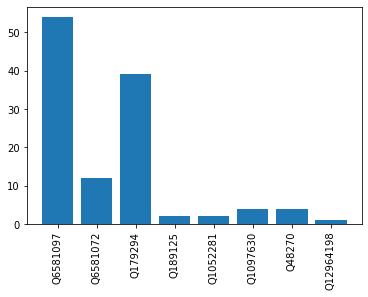

In [36]:
import matplotlib.pyplot as plt
plt.bar(genders.keys(), genders.values())
plt.xticks(rotation = 90);

In [35]:
speaker_data.loc[speaker_data["id"] == 'Q15735939']

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
7078648,[Christopher Douglas Matthews],[+1989-10-06T00:00:00Z],[Q30],[Q6581097],1317867389,[Q49085],None,"[Q19204627, Q19841381]",None,None,Q15735939,Chris Matthews,None,item,None
